In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
from torchvision import datasets
data_path = './dlpytorch/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./dlpytorch/cifar-10-python.tar.gz to ./dlpytorch/
Files already downloaded and verified


In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [ ]:
len(cifar10)

50000

Images

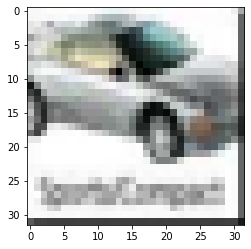

In [4]:
img, label = cifar10[79]
plt.imshow(img)
plt.show()

In [5]:
print(f"Label:{label} - Class:{class_names[label]}")

Label:1 - Class:automobile


In [6]:
from torchvision import transforms
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [22]:
tensor_c10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())

In [23]:
# load the same image and view the the tensor shape and type
img_t, _ = tensor_c10[79]
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

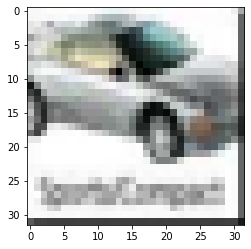

In [ ]:
# Permute columns and visualize image again
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

In [ ]:
# Normalizing data
# 1. stack the dataset tensors along an extra dimension
imgs = torch.stack([img_t for img_t, _ in tensor_c10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [ ]:
# 2. compute mean per channel
imgs.view(3, -1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

In [ ]:
# 3. compute std deviation
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [7]:
# 4 normalize the data 
normalized_c10 = datasets.CIFAR10(data_path, train=True, download=False,
                                       transform=transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.4915, 0.4823, 0.4468),(0.2470, 0.2435, 0.2616))
                                        ]))
normalized_c10_val = datasets.CIFAR10(data_path, train=False, download=False,
                                       transform=transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.4915, 0.4823, 0.4468),(0.2470, 0.2435, 0.2616))
                                        ]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


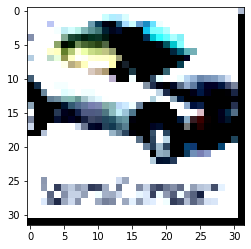

In [8]:
# view normalized image
img_t, _ = normalized_c10[79]
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

In [ ]:
img_t.view(-1)

tensor([ 1.9476,  1.9476,  1.9793,  ..., -0.7485, -0.7635, -1.3332])

In [ ]:
# fully connected NN
fc_model = nn.Sequential(
          nn.Linear(3072, 1024),
          nn.Tanh(),
          nn.Linear(1024, 512),
          nn.Tanh(),
          nn.Linear(512, 128),
          nn.Tanh(),
          nn.Linear(128, 10))

In [ ]:
# how many parameters have our fully connected NN ?
param_list = [p.numel()
              for p in fc_model.parameters()]
sum(param_list), param_list

(3738506, [3145728, 1024, 524288, 512, 65536, 128, 1280, 10])

Convolutions

In [9]:
# create Conv2d
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [ ]:
# Apply convolution
output = conv(img_t.unsqueeze(0))
img_t.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

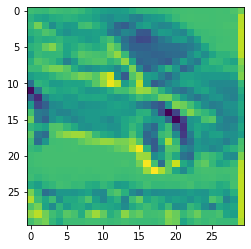

In [ ]:
plt.imshow(output[0, 0].detach())
plt.show()

In [ ]:
# create new conv to perform edge detection
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
# disable gradient calculation and set the weights
with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

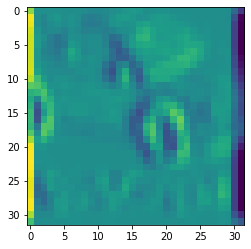

In [ ]:
output = conv(img_t.unsqueeze(0))
plt.imshow(output[0, 0].detach())
plt.show()

Downsampling

In [10]:
# CNN combining convolutions and pooling
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 10))

In [11]:
# how many parameters ?
# 18354 vs 3738506 of a Fully connected NN
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18354, [432, 16, 1152, 8, 16384, 32, 320, 10])

In [ ]:
# if we apply a model to an image there was an error
# The layer that has a 512x32 is Linear, the 1sr after the last Convolution
# we must reshape from an 8 channels * 8 * 8 image to 512 1D vector
model(img_t.unsqueeze(0))

RuntimeError: ignored

So, we must reshape from an 8 channels * 8 * 8 image to 512 1D vector.

This could be achieved by calling view on the output of the last nn.MaxPool2d, but unfortunately, we don’t have any explicit visibility of the output of each module when we use nn.Sequential.

**A new Net subclass**

When we want to build models that do more complex things than just applying
one layer after another, we need to leave nn.Sequential for something that gives us added flexibility. 

PyTorch allows us to use any computation in our model by subclassing nn.Module.

In [9]:
# The solution: make our own nn.module subclass

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.act1 = nn.Tanh()
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
    self.act2 = nn.Tanh()
    self.pool2 = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(8 * 8 * 8, 32)
    self.act3 = nn.Tanh()
    self.fc2 = nn.Linear(32, 10)

  # That takes the inputs to the module and returns the output
  def forward(self, x):
    out = self.pool1(self.act1(self.conv1(x)))
    out = self.pool2(self.act2(self.conv2(out)))
    out = out.view(-1, 8 * 8 * 8)  # the reshape to 1D 512 elements
    out = self.act3(self.fc1(out))
    out = self.fc2(out)
    return out

In [10]:
# we obtain 10 probabilities, 1 per class in the Cifar10 Dataset
model = Net()
model(img_t.unsqueeze(0))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([[-0.0210, -0.1683, -0.1605, -0.1527, -0.0665,  0.0812,  0.0407,  0.3059,
         -0.2734,  0.0747]], grad_fn=<AddmmBackward>)

In [11]:
# Refactor the Net subclass to use funct. Api for Activat.funct. and Pooling

import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
      self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
      self.fc1 = nn.Linear(8 * 8 * 8, 32)
      self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
      out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
      out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
      out = out.view(-1, 8 * 8 * 8)
      out = torch.tanh(self.fc1(out))
      out = self.fc2(out)
      return out

We build a new dataset Cifar3 to have only 3 classes and down the training times

Selected classes:(0,1,8) ==> airplanes, automobiles and ships

In [12]:
label_map = {0: 0, 1: 1, 2: 8}
class_names = ['airplane', 'automobile', 'ship']
cifar3 = [(img, label_map[label])
          for img, label in normalized_c10
          if label in [0, 1, 2]]
cifar3_val = [(img, label_map[label])
              for img, label in normalized_c10_val
              if label in [0, 1, 2]]

In [13]:
len(cifar3)

15000

In [14]:
# Training the Net CNN
import datetime

def training_net(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0

        # The DataLoader (train_loader) create batches of 64 imgs (batch_size)
        for imgs, labels in train_loader:
            outputs = model(imgs)
            # compute the loss to minimize
            loss = loss_fn(outputs, labels)
            # put 0 the grads of the last round, compute new grads and update model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # sums the losses we saw over the epoch
            # item() to transform loss to a python number
            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
            datetime.datetime.now(), epoch,
            loss_train / len(train_loader)))

In [17]:
train_loader = torch.utils.data.DataLoader(cifar3, batch_size=64,
                shuffle=True)
model = Net() 
optimizer = optim.SGD(model.parameters(), lr=1e-2) 
loss_fn = nn.CrossEntropyLoss() 
training_net(
              n_epochs = 100,
              optimizer = optimizer,
              model = model,
              loss_fn = loss_fn,
              train_loader = train_loader,
              )

2021-08-27 22:57:00.749292 Epoch 1, Training loss 1.2701365361822412
2021-08-27 22:58:00.659047 Epoch 10, Training loss 0.46784308286423376
2021-08-27 22:59:07.458263 Epoch 20, Training loss 0.3864203170258948
2021-08-27 23:00:14.444214 Epoch 30, Training loss 0.33741789929410243
2021-08-27 23:01:21.231439 Epoch 40, Training loss 0.30020717325362756
2021-08-27 23:02:28.281510 Epoch 50, Training loss 0.27134481427517343
2021-08-27 23:03:35.316213 Epoch 60, Training loss 0.2446697694190005
2021-08-27 23:04:42.019898 Epoch 70, Training loss 0.22236480332435446
2021-08-27 23:05:49.538417 Epoch 80, Training loss 0.2021198609090866
2021-08-27 23:06:56.730044 Epoch 90, Training loss 0.1850982147011351
2021-08-27 23:08:04.466594 Epoch 100, Training loss 0.16812258313627954


In [15]:
# build the data loaders for train and validation
train_loader = torch.utils.data.DataLoader(cifar3, batch_size=64,shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar3_val, batch_size=64,shuffle=False)

In [18]:
# measure the accuracy using the validation dataset
def validate_net(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        # don't want grads here
        with torch.no_grad():
          for imgs, labels in loader:
              outputs = model(imgs)
              # gives the index of the highest value of outputs
              _, predicted = torch.max(outputs, dim=1)
              # increased total with batch size
              total += labels.shape[0]
              # Comparing the predicted class that had the maximum probability 
              # with the correct label. The sum gives the number of items are agree
              correct += int((predicted == labels).sum())
        print(f"Accuracy {name}: {correct / total}")

validate_net(model, train_loader, val_loader)

Accuracy train: 0.9195333333333333
Accuracy val: 0.8613333333333333


In [19]:
# save model parameters (weights and biases)
torch.save(model.state_dict(), data_path + 'cifar3_train_params.pt')

In [20]:
# load model
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + 'cifar3_train_params.pt'))

<All keys matched successfully>